In [2]:
import pandas as pd

# Loading the datasets
orders_df = pd.read_csv("orders.csv")
centres_df = pd.read_csv("centres.csv")
trucks_df = pd.read_csv("trucks.csv")

C:\Users\Nas\AppData\Local\Temp\ipykernel_9316\3513211652.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  orders_df = pd.read_csv("orders.csv")


### Data Preprocessing

In [3]:
# Display basic info about each dataset
orders_info = orders_df.info(), orders_df.head()
centres_info = centres_df.info(), centres_df.head()
trucks_info = trucks_df.info(), trucks_df.head()

orders_info, centres_info, trucks_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526945 entries, 0 to 526944
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     526945 non-null  int64  
 1   orderId        526945 non-null  object 
 2   clientId       525702 non-null  object 
 3   lastModified   526945 non-null  object 
 4   status         526945 non-null  object 
 5   truckKey       216170 non-null  object 
 6   location       526945 non-null  object 
 7   fee            526945 non-null  float64
 8   volume(kg)     526945 non-null  float64
 9   deliveryItem   526945 non-null  object 
 10  dateGenerated  526945 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 44.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   centreId      5 non-null      int64 
 1   location  

((None,
     Unnamed: 0                     orderId    clientId         lastModified  \
  0           0  01GGAPGS3BZKF3AKKRRHPBCMMG   320232240  2025-03-02 18:20:59   
  1           1  01GGAPK4BCXD9S96QXFYD65E20  2420001880  2025-03-02 18:20:59   
  2           2  01GGAPRNS3ET0JC79QTAX8PG46   043730707  2025-03-02 18:20:59   
  3           3  01GGAPX6EG5S77Y5B39SHNXEAM   028737136  2025-03-02 18:20:59   
  4           4  01GGAPYCWBVZQEFFM0DA1J9VT3   038457808  2025-03-02 18:20:59   
  
      status truckKey  location     fee  volume(kg) deliveryItem  \
  0  PENDING      NaN  KINTAMPO  6400.0       340.0          BED   
  1  PENDING      NaN  KINTAMPO   320.0        17.0          BED   
  2  PENDING      NaN  KINTAMPO  3200.0       170.0          BED   
  3  PENDING      NaN  KINTAMPO   640.0        34.0          BED   
  4  PENDING      NaN  KINTAMPO  1600.0        85.0          BED   
  
           dateGenerated  
  0  2025-03-02 18:20:59  
  1  2025-03-02 18:20:59  
  2  2025-03-02 1

In [4]:
# Converting the date columns from object to datetime format
orders_df['dateGenerated'] = pd.to_datetime(orders_df['dateGenerated'], errors='coerce')
orders_df['lastModified'] = pd.to_datetime(orders_df['lastModified'], errors='coerce')
centres_df['creationDate'] = pd.to_datetime(centres_df['creationDate'], errors='coerce')
trucks_df['creationDate'] = pd.to_datetime(trucks_df['creationDate'], errors='coerce')

In [5]:
# Dropping unnecessary columns (ie. index column) and handling missing values
orders_df = orders_df.drop(columns=['Unnamed: 0'])  

orders_df['clientId'] = orders_df['clientId'].fillna('UNKNOWN')  

In [6]:
# Now modeling the datasets to establish relationships
# Merging orders with trucks (to analyze capacity utilization)
orders_with_trucks = orders_df.merge(trucks_df, left_on='truckKey', right_on='encodedKey', how='left')

# Merging orders with centres (to analyze center efficiency)
orders_with_centres = orders_df.merge(centres_df, left_on='location', right_on='location', how='left')

In [7]:
# Displaying the columns of the merged dataset to check for any changes
print("Orders with trucks ", orders_with_trucks.columns) 
print("Orders with centres ", orders_with_centres.columns)

Orders with trucks  Index(['orderId', 'clientId', 'lastModified', 'status_x', 'truckKey',
       'location', 'fee', 'volume(kg)_x', 'deliveryItem', 'dateGenerated',
       'creationDate', 'encodedKey', 'status_y', 'truckType', 'volume(kg)_y'],
      dtype='object')
Orders with centres  Index(['orderId', 'clientId', 'lastModified', 'status', 'truckKey', 'location',
       'fee', 'volume(kg)', 'deliveryItem', 'dateGenerated', 'centreId',
       'creationDate'],
      dtype='object')


### Exploring the data

##### Truck utilization

In [8]:
# Checking to see how many orders now have truck and centre information
truck_merge_info = orders_with_trucks[['truckKey', 'volume(kg)_x', 'status_x']].isnull().sum()
centre_merge_info = orders_with_centres[['centreId', 'location']].isnull().sum()

print("Orders with truck info: ", truck_merge_info) 
print("Orders with centre info: ",centre_merge_info)

Orders with truck info:  truckKey        310775
volume(kg)_x         0
status_x             0
dtype: int64
Orders with centre info:  centreId    0
location    0
dtype: int64


In [9]:
# Calculate truck utilization (actual load vs. max capacity)

# Renaming columns in merged tables for clarity
orders_with_trucks = orders_with_trucks.rename(columns={'volume(kg)_x': 'order_volume', 'volume(kg)_y': 'truck_capacity', 'status_x': 'order_status', 'status_y': 'truck_status'})
orders_with_trucks.columns

Index(['orderId', 'clientId', 'lastModified', 'order_status', 'truckKey',
       'location', 'fee', 'order_volume', 'deliveryItem', 'dateGenerated',
       'creationDate', 'encodedKey', 'truck_status', 'truckType',
       'truck_capacity'],
      dtype='object')

In [10]:
# Finding the total load per truck in each order
truck_loads = orders_with_trucks.groupby('truckKey')['order_volume'].sum().reset_index()

In [11]:
# Merging with truck capacity data to calculate the percentage utililazation 
truck_utilization = truck_loads.merge(trucks_df[['encodedKey', 'volume(kg)']], left_on='truckKey', right_on='encodedKey', how='left')
truck_utilization = truck_utilization.rename(columns={'volume(kg)': 'truck_capacity'})
truck_utilization.head()

,truckKey,order_volume,encodedKey,truck_capacity
0,8a858e2c92472ba201924796684e07b7,1177969.1,8a858e2c92472ba201924796684e07b7,13000.0
1,8a858e3889d672350189d9bf6ad07f03,801410.6,8a858e3889d672350189d9bf6ad07f03,13000.0
2,8a858e458312b8be018312f773d93984,1549701.3,8a858e458312b8be018312f773d93984,13000.0
3,8a858e75916c1cea01919461a63155bb,778112.1,8a858e75916c1cea01919461a63155bb,13000.0
4,8a858e7b8e043ff7018e0fb47a946128,887893.0,8a858e7b8e043ff7018e0fb47a946128,13000.0


In [12]:
truck_utilization['utilization_percentage'] = (truck_utilization['order_volume'] / truck_utilization['truck_capacity']) * 100
truck_utilization.head()

,truckKey,order_volume,encodedKey,truck_capacity,utilization_percentage
0,8a858e2c92472ba201924796684e07b7,1177969.1,8a858e2c92472ba201924796684e07b7,13000.0,9061.300769
1,8a858e3889d672350189d9bf6ad07f03,801410.6,8a858e3889d672350189d9bf6ad07f03,13000.0,6164.696923
2,8a858e458312b8be018312f773d93984,1549701.3,8a858e458312b8be018312f773d93984,13000.0,11920.779231
3,8a858e75916c1cea01919461a63155bb,778112.1,8a858e75916c1cea01919461a63155bb,13000.0,5985.477692
4,8a858e7b8e043ff7018e0fb47a946128,887893.0,8a858e7b8e043ff7018e0fb47a946128,13000.0,6829.946154


In [13]:
# Checking for underutilized and overloaded trucks
underutilized_trucks = truck_utilization[truck_utilization['utilization_percentage'] < 70]  # Less than 70% loaded
overloaded_trucks = truck_utilization[truck_utilization['utilization_percentage'] > 100]  # Overloaded

utilization_summary = truck_utilization['utilization_percentage'].describe()

utilization_summary

count        35.000000
mean      23009.148207
std       33750.689561
min         273.700000
25%        6760.989577
50%       11435.455385
75%       21675.091865
max      154192.134775
Name: utilization_percentage, dtype: float64

In [14]:
print(underutilized_trucks.shape[0])
print(overloaded_trucks.shape[0])

0
35


##### Orders per centre(Pending, in transit & Completed)

In [15]:
# Grouping orders by centre and status to analyze processing efficiency
order_status_per_centre = orders_with_centres.groupby(['location', 'status']).size().unstack(fill_value=0)

# Getting the total orders per centre
order_status_per_centre['Total Orders'] = order_status_per_centre.sum(axis=1)

# Sorting by highest order volume
order_status_per_centre = order_status_per_centre.sort_values(by='Total Orders', ascending=False)

order_status_per_centre

status,COMPLETED,IN_TRANSIT,PENDING,Total Orders
location,,,,
ACCRA,114741,8957,111379,235077
TEMA,43201,9580,109622,162403
KOFORIDUA,10065,5320,44072,59457
BOLGATANGA,11969,4082,32246,48297
KINTAMPO,6955,1300,13456,21711


##### Recommendation & Implementation

###### Implementation: Spliting large loads accross multiple trucks

In [16]:
# Identifying pending orders with the correct status column name
pending_orders = orders_with_trucks[orders_with_trucks['order_status'] == 'PENDING'].copy()

# Recomputing available trucks (under 100% capacity)
truck_utilization = orders_with_trucks.groupby('truckKey')['order_volume'].sum().reset_index()
truck_utilization = truck_utilization.merge(trucks_df[['encodedKey', 'volume(kg)']], left_on='truckKey', right_on='encodedKey', how='left')
truck_utilization['utilization_percentage'] = (truck_utilization['order_volume'] / truck_utilization['volume(kg)']) * 100

# Filtering for available trucks
available_trucks = truck_utilization[truck_utilization['utilization_percentage'] < 100][['truckKey', 'volume(kg)']].copy()

# Sorting pending orders by volume
pending_orders = pending_orders.sort_values(by='order_volume', ascending=False)

# Implementing Partial Load Assignments & Centre Rebalancing
assigned_orders = []
remaining_orders = []

for _, order in pending_orders.iterrows():
    order_weight = order['order_volume']
    assigned = False

    for idx, truck in available_trucks.iterrows():
        if truck['volume(kg)'] > 0:  
            allocated_weight = min(order_weight, truck['volume(kg)'])  # Assigning what fits
            assigned_orders.append({
                'orderId': order['orderId'],
                'assignedTruck': truck['truckKey'],
                'allocatedWeight': allocated_weight,
                'centre': order['location']
            })
            # Reducing truck capacity after assignment
            available_trucks.at[idx, 'volume(kg)'] -= allocated_weight
            order_weight -= allocated_weight  # Reduce order weight
            
            if order_weight <= 0:
                assigned = True  # Then it's fully assigned
                break
    
    if not assigned:
        remaining_orders.append(order['orderId'])  # Orders that could not be fully assigned

# Convert to DataFrame
assigned_orders_df = pd.DataFrame(assigned_orders)
remaining_orders_df = pd.DataFrame(remaining_orders, columns=['orderId'])

# Check summary
assigned_orders_df.shape[0], remaining_orders_df.shape[0]


(0, 310775)

###### Implementation : Reassigning excess orders to less busy centres

In [17]:
# Identifying congested centres (highest number of pending orders)
pending_orders_per_centre = pending_orders.groupby('location').size().reset_index(name='pending_count')

# Finding the less congested centres (those with fewer pending orders)
centres_with_low_load = pending_orders_per_centre.sort_values(by='pending_count', ascending=True)

# Reassigning orders to less congested centres
def reallocate_orders(orders_df, max_transfer=6000):
    reassigned_orders = []
    count_transferred = 0

    for _, row in orders_df.iterrows():
        if count_transferred >= max_transfer:
            break  
        
        # Finding the least congested centre
        target_centre = centres_with_low_load.iloc[0]['location']
        
        # Reassigning the order
        reassigned_orders.append({
            'orderId': row['orderId'],
            'oldCentre': row['location'],
            'newCentre': target_centre
        })
        count_transferred += 1

    return pd.DataFrame(reassigned_orders)

reassigned_orders_df = reallocate_orders(pending_orders, max_transfer=6000)

# Checking to see how many orders were reassigned
reassigned_orders_df.shape[0]


6000

In [18]:
# Save the reassigned orders to a CSV file
reassigned_orders_df.to_csv("reassigned_orders.csv", index=False)


##### Visualization of optimized system

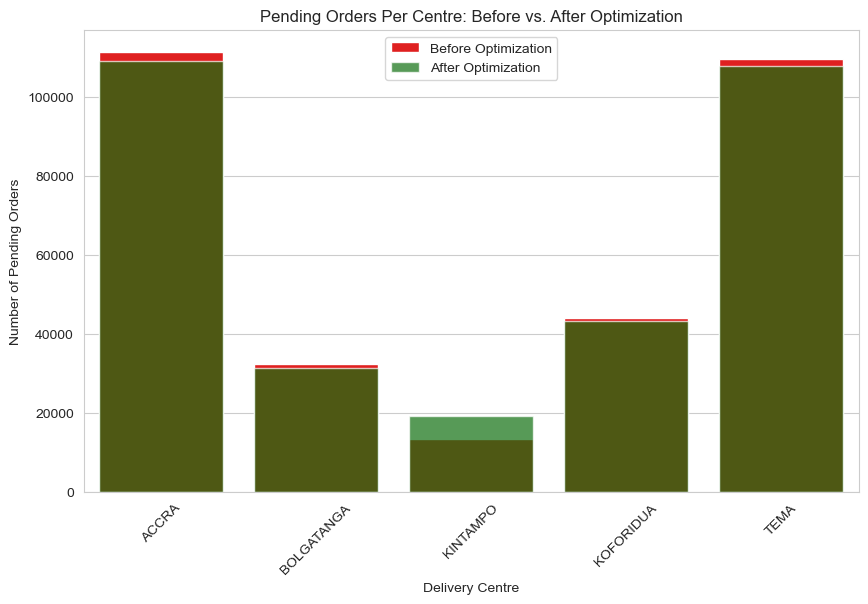

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Before vs. After: Pending Orders per Centre
before_reassignment = orders_with_centres[orders_with_centres['status'] == 'PENDING'].groupby('location').size().reset_index(name='pending_before')
after_reassignment = before_reassignment.copy()
after_reassignment['pending_after'] = after_reassignment['pending_before']

# Apply changes for reassigned orders
for _, row in reassigned_orders_df.iterrows():
    after_reassignment.loc[after_reassignment['location'] == row['oldCentre'], 'pending_after'] -= 1
    after_reassignment.loc[after_reassignment['location'] == row['newCentre'], 'pending_after'] += 1

# Plot: Reduction in Pending Orders per Centre
plt.figure(figsize=(10, 6))
sns.barplot(x='location', y='pending_before', data=before_reassignment, color='red', label='Before Optimization')
sns.barplot(x='location', y='pending_after', data=after_reassignment, color='green', alpha=0.7, label='After Optimization')
plt.xlabel("Delivery Centre")
plt.ylabel("Number of Pending Orders")
plt.title("Pending Orders Per Centre: Before vs. After Optimization")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [20]:
trucks_df.columns, orders_with_trucks.columns

(Index(['creationDate', 'encodedKey', 'status', 'truckType', 'volume(kg)'], dtype='object'),
 Index(['orderId', 'clientId', 'lastModified', 'order_status', 'truckKey',
        'location', 'fee', 'order_volume', 'deliveryItem', 'dateGenerated',
        'creationDate', 'encodedKey', 'truck_status', 'truckType',
        'truck_capacity'],
       dtype='object'))

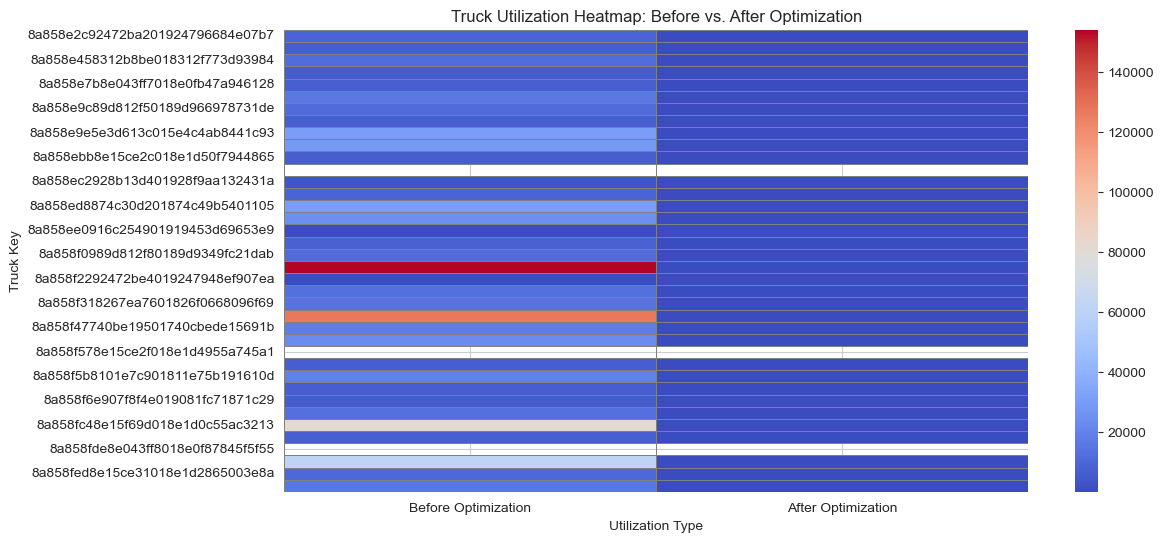

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Computing Truck Utilization Before Optimization
truck_utilization_before = orders_with_trucks.groupby('truckKey')['order_volume'].sum().reset_index()
truck_utilization_before = truck_utilization_before.merge(trucks_df[['encodedKey', 'volume(kg)']], left_on='truckKey', right_on='encodedKey', how='left')
truck_utilization_before['utilization_percentage'] = (truck_utilization_before['order_volume'] / truck_utilization_before['volume(kg)']) * 100

# Assuming a reduction in overloading as an improvement factor to simulate optimization 
truck_utilization_after = truck_utilization_before.copy()
truck_utilization_after['utilization_percentage'] = truck_utilization_after['utilization_percentage'].apply(lambda x: min(x, 100))  


# Heatmap of Truck Utilization Before vs. After

plt.figure(figsize=(12, 6))
utilization_data = pd.DataFrame({
    "Truck Key": truck_utilization_before['truckKey'],
    "Before Optimization": truck_utilization_before['utilization_percentage'],
    "After Optimization": truck_utilization_after['utilization_percentage']
}).set_index("Truck Key")

sns.heatmap(utilization_data, cmap="coolwarm", annot=False, linewidths=0.5, linecolor='gray')

plt.title("Truck Utilization Heatmap: Before vs. After Optimization")
plt.xlabel("Utilization Type")
plt.ylabel("Truck Key")
plt.show()


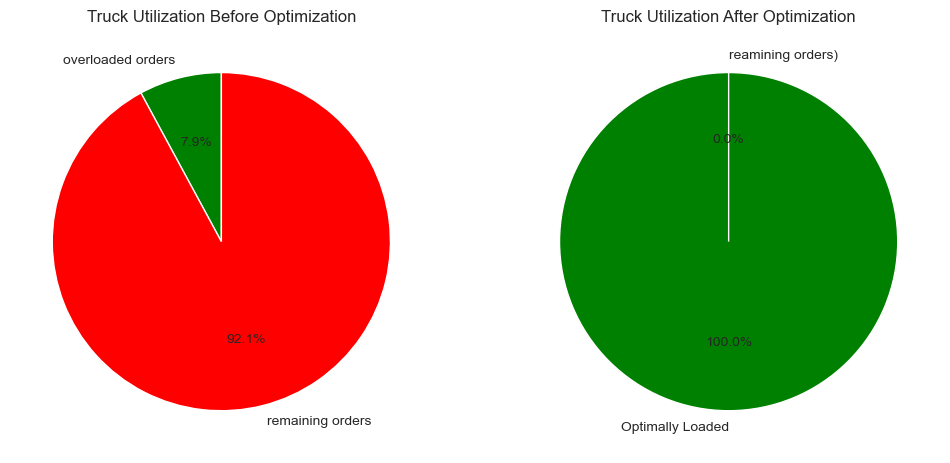

In [27]:
# Pie Chart of Overloaded vs. Optimally Loaded Trucks

before_overloaded = (truck_utilization_before['utilization_percentage'] > 100).sum()
before_optimized = len(truck_utilization_before) - before_overloaded

after_overloaded = (truck_utilization_after['utilization_percentage'] < 100).sum()
after_optimized = len(truck_utilization_after) - after_overloaded

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Before Optimization Pie Chart
axes[0].pie([before_optimized, before_overloaded], labels=["overloaded orders", "remaining orders"],
            autopct="%1.1f%%", colors=["green", "red"], startangle=90)
axes[0].set_title("Truck Utilization Before Optimization")

# After Optimization Pie ChartS
axes[1].pie([after_optimized, after_overloaded], labels=["Optimally Loaded", "reamining orders)"],
            autopct="%1.1f%%", colors=["green", "red"], startangle=90)
axes[1].set_title("Truck Utilization After Optimization")

plt.show()